In [ ]:
# %pip install captcha 
# %pip install opencv-python
# !apt update && apt install -y libsm6 libxext6
# !pip install opencv-python-headless
# !pip install opencv-contrib-python-headless
# %pip install keras
# !pip install opencv-python

import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

In [11]:
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [12]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [13]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [14]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 8 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
generating 1/8
generating 2/8
generating 3/8
generating 4/8
generating 5/8
generating 6/8
generating 7/8
generating 8/8
Finished Data Generation


In [19]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 241920 (train=217921, test=23999)


In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(217921, 25, 67, 1)
(217921, 5, 10)
(23999, 25, 67, 1)
(23999, 5, 10)


In [21]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [22]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [23]:
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = Model(inputs=input_layer, outputs=out)

In [ ]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 67, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 25, 67,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 33,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 12, 33,    │     38,448 │ max_pooling2d[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 16, 48) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 16, 64) │     76,864 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 8, 64)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 8, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1536)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    786,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit0 (Dense)      │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1 (Dense)      │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2 (Dense)      │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3 (Dense)      │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4 (Dense)      │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 928,738 (3.54 MB)

 Trainable params: 928,738 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [27]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'] * 5)  # Assuming 5 outputs

In [30]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test))

Epoch 1/50
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 173s 101ms/step - digit0_accuracy: 0.5139 - digit0_loss: 1.2845 - digit1_accuracy: 0.4266 - digit1_loss: 1.5430 - digit2_accuracy: 0.4056 - digit2_loss: 1.6180 - digit3_accuracy: 0.4428 - digit3_loss: 1.5073 - digit4_accuracy: 0.5149 - digit4_loss: 1.2824 - loss: 7.2351 - val_digit0_accuracy: 0.9809 - val_digit0_loss: 0.0627 - val_digit1_accuracy: 0.9600 - val_digit1_loss: 0.1353 - val_digit2_accuracy: 0.9535 - val_digit2_loss: 0.1694 - val_digit3_accuracy: 0.9578 - val_digit3_loss: 0.1436 - val_digit4_accuracy: 0.9803 - val_digit4_loss: 0.0622 - val_loss: 0.5736
Epoch 2/50
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 157s 92ms/step - digit0_accuracy: 0.9661 - digit0_loss: 0.1047 - digit1_accuracy: 0.9252 - digit1_loss: 0.2370 - digit2_accuracy: 0.9145 - digit2_loss: 0.2759 - digit3_accuracy: 0.9317 - digit3_loss: 0.2174 - digit4_accuracy: 0.9635 - digit4_loss: 0.1134 - loss: 0.9484 - val_digit0_accuracy: 0.9924 - val_digit0_loss: 0.0247 - val_digit1_accurac

In [33]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

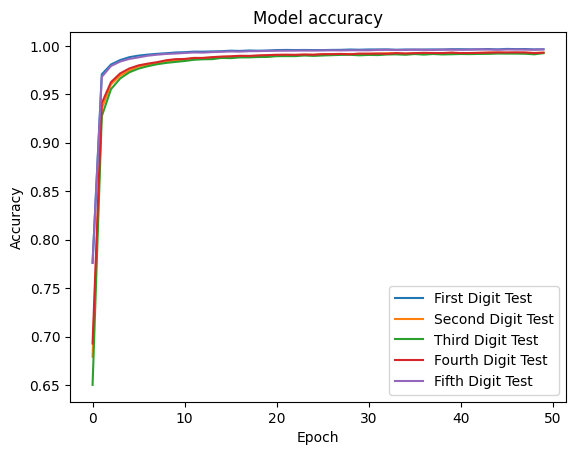

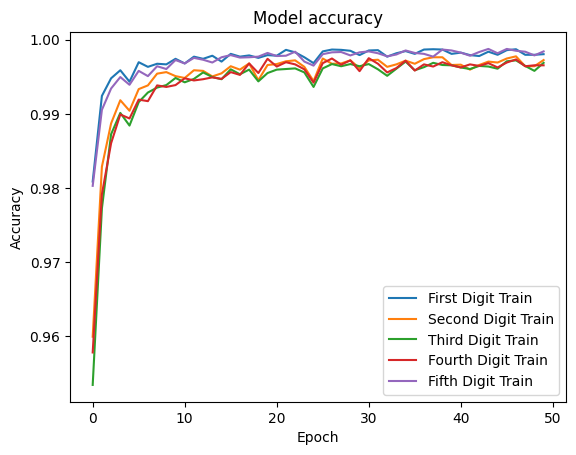

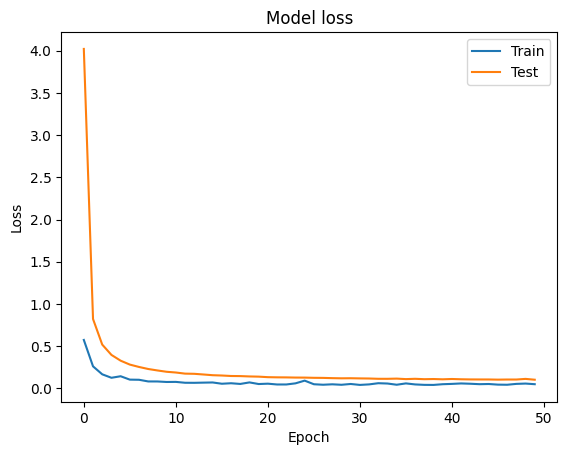

In [34]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [35]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/zaraanry/workspace/captcha/saved_models/keras_cifar10_trained_model.h5 


In [36]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

6811/6811 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - digit0_accuracy: 0.9994 - digit0_loss: 0.0020 - digit1_accuracy: 0.9987 - digit1_loss: 0.0045 - digit2_accuracy: 0.9988 - digit2_loss: 0.0043 - digit3_accuracy: 0.9987 - digit3_loss: 0.0037 - digit4_accuracy: 0.9993 - digit4_loss: 0.0023 - loss: 0.0168
Train loss:     0.006549
Train accuracy: 99.46


In [37]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - digit0_accuracy: 0.9981 - digit0_loss: 0.0068 - digit1_accuracy: 0.9973 - digit1_loss: 0.0104 - digit2_accuracy: 0.9970 - digit2_loss: 0.0153 - digit3_accuracy: 0.9967 - digit3_loss: 0.0101 - digit4_accuracy: 0.9983 - digit4_loss: 0.0062 - loss: 0.0488
Test loss:     0.018453
Test accuracy: 98.72
